# "What is known" panel
Previous studies have linked the aperiodic offset to neuronal spiking, and the 
aperiodic exponent to E/I balance.

## Set-up

### imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox

from neurodsp.spectral import compute_spectrum
from specparam.plts.spectra import plot_spectrum


In [3]:
# custom imports
import sys
sys.path.append('../../code')
from paths import EXTERNAL_PATH
from spike_utils import sample_spikes, convolve_psps, get_spike_times


### settings

In [4]:
# simulation settings
N_SECONDS = 100
FS = 1000 # sampling frequency
N_NEURONS = 100
MEAN_RATE = 10 # average rate of each neuron (Hz)

# random process params
ALPHA = 1.
TAU_C = 25 / 1000

In [5]:
# matplotlib and figure appearance settings
# plt.style.use(f'../../mpl_styles/sfn_2024.mplstyle')
COLORS = ["#7570b3", "#3FAA96", "#F39943"]

# set RC params (NOTE: font in sfn_2024.mplstyle does not include needed symbols)
from matplotlib import rcParams
rcParams['font.size'] = 16
rcParams['figure.titlesize'] = 25
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['figure.facecolor'] = 'w'
rcParams['axes.facecolor'] = 'w'


### Create output directory

In [6]:
dir_out = f"{EXTERNAL_PATH}/figures/sfn_2024"
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

### functions

In [7]:
def sim_lfp(n_neurons=1000, mean_rate=2, n_seconds=10, fs=1000, 
            tau_rise=0., tau_decay=0.01, return_spikes=False):
    # imports
    from scipy.signal import detrend

    # simulate spiking
    spikes = []
    for i_neuron in range(n_neurons):
        rand_white = np.random.normal(loc=mean_rate, scale=mean_rate**0.5, size=n_seconds*fs)
        spikes_i = sample_spikes(rand_white, fs)
        spikes.append(spikes_i)
    spikes = np.array(spikes)
        
    # get spike times
    time = np.linspace(0, n_seconds, spikes.shape[1])
    spike_times = []
    for i_cell in range(len(spikes)):
        spike_times.append(get_spike_times(spikes[i_cell], time))

    # simulate LFP
    pop_spikes = np.sum(spikes, axis=0)
    lfp, time = convolve_psps(pop_spikes, fs, tau_r=tau_rise, tau_d=tau_decay)
    lfp = detrend(lfp, type='constant')

    # TEMP - correct time vector (this in a bug in convolve_psps)
    n_samples_dropped = len(time) - len(lfp)
    time = time[:-n_samples_dropped]

    if return_spikes:
        return spikes, spike_times, lfp, time
    else:
        return lfp, time


## Main

### simulate LFP

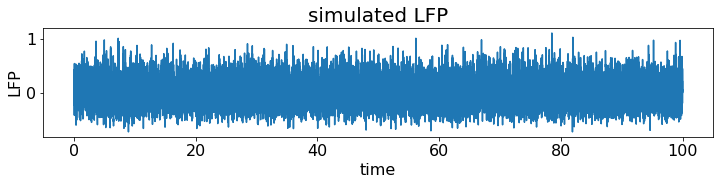

Text(0.5, 1.0, 'PSD of simulated LFP')

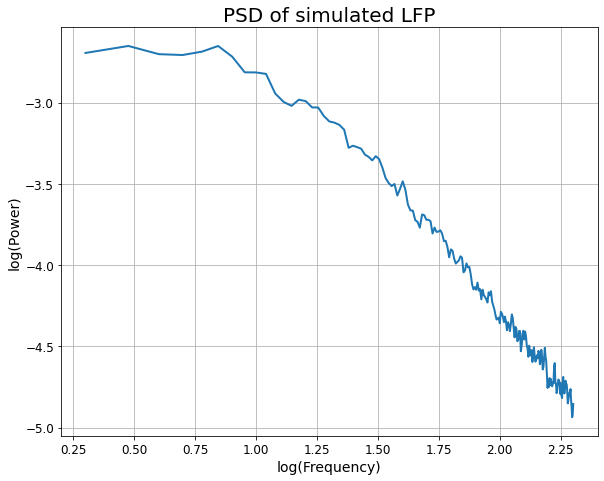

In [8]:
# simulate LFP 

# simulate LFP
spikes, spike_times, lfp, time = sim_lfp(n_neurons=N_NEURONS, mean_rate=MEAN_RATE, 
                                n_seconds=N_SECONDS, fs=FS, return_spikes=True)
freq, spectra = compute_spectrum(lfp, FS, f_range=[2,200])

# plot LFP time-series
fig, ax = plt.subplots(1,1, figsize=[12,2])
ax.plot(time, lfp)
ax.set(xlabel="time", ylabel="LFP")
ax.set_title("simulated LFP")
plt.show()

# plot spectrum
plot_spectrum(freq, spectra, log_freqs=True, log_powers=True)
ax = plt.gca()
ax.set_title("PSD of simulated LFP")


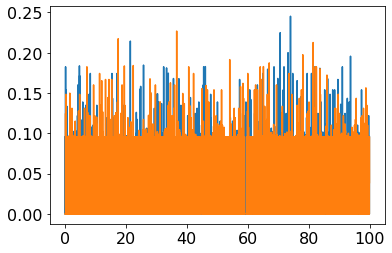

In [9]:
# plot conductance trace of each neuron

# compute traces
traces = []

for i_spiketrain in range(len(spikes)):
    i_trace, spike_time_vector = convolve_psps(spikes[i_spiketrain], FS)
    traces.append(i_trace)
traces = np.array(traces)
spike_time_vector = spike_time_vector[:traces.shape[1]] # TEMP - bug in convolve_psps
plt.plot(spike_time_vector, traces[:2].T);

### increase rate
offset : firing rate (Miller, 2009)

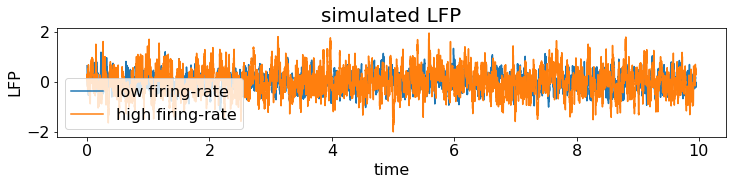

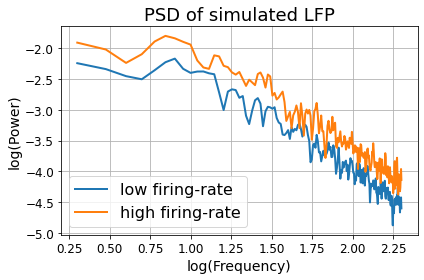

In [10]:
# simulate LFP with increased rate

# simulate LFP
spikes_0, spike_times_0, lfp_0, t_lfp_0 = sim_lfp(mean_rate=2, fs=FS, return_spikes=True)
spikes_1, spike_times_1, lfp_1, _ = sim_lfp(mean_rate=5, fs=FS, return_spikes=True)

# compute PSD
freq, spectra_0 = compute_spectrum(lfp_0, FS, f_range=[2,200])
freq, spectra_1 = compute_spectrum(lfp_1, FS, f_range=[2,200])

# plot LFP time-series
fig, ax = plt.subplots(1,1, figsize=[12,2])
ax.plot(t_lfp_0, lfp_0, label='low firing-rate')
ax.plot(t_lfp_0, lfp_1, label='high firing-rate')
ax.set(xlabel="time", ylabel="LFP")
ax.set_title("simulated LFP")
ax.legend()
plt.show()

# plot spectrum
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_title("PSD of simulated LFP")
plot_spectrum(freq, spectra_0, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq, spectra_1, log_freqs=True, log_powers=True, ax=ax)
ax.legend(labels=["low firing-rate","high firing-rate"])

### introduce excitatory and inhibitory population
exponent : EI balance (Gao, 2017)

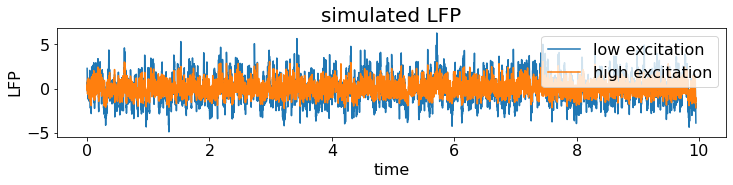

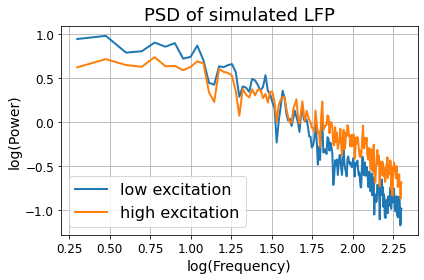

In [11]:
# simulate LFP with increased rate

# simulate excitatory and inhibitory fields
spikes_e, spiketimes_e, conductance_e, time_e = sim_lfp(n_neurons=800, mean_rate=2, tau_rise=0.0001, tau_decay=.002, return_spikes=True)
spikes_i, spiketimes_i, conductance_i, time_i = sim_lfp(n_neurons=200, mean_rate=5, tau_rise=0.0005, tau_decay=.01, return_spikes=True)

# TEMP ! trim to same length
n_samples = np.min([len(conductance_e), len(conductance_i)]) 
conductance_e = conductance_e[:n_samples]
conductance_i = conductance_i[:n_samples]
t_lfp_2 = time_e[:n_samples]

# combine LFP
lfp_2 = conductance_e + 6 * conductance_i
lfp_3 = conductance_e + 2 * conductance_i

# compute PSD and normalize
freq, spectra_2 = compute_spectrum(lfp_2, FS, f_range=[2,200])
freq, spectra_3 = compute_spectrum(lfp_3, FS, f_range=[2,200])
spectra_2 = spectra_2 / np.mean(spectra_2)
spectra_3 = spectra_3 / np.mean(spectra_3)

# plot LFP time-series
fig, ax = plt.subplots(1,1, figsize=[12,2])
ax.plot(t_lfp_2, lfp_2-np.mean(lfp_2), label='low excitation')
ax.plot(t_lfp_2, lfp_3-np.mean(lfp_3), label='high excitation')
ax.set(xlabel="time", ylabel="LFP")
ax.set_title("simulated LFP")
ax.legend()
plt.show()

# plot spectrum
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_title("PSD of simulated LFP")
plot_spectrum(freq, spectra_2, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq, spectra_3, log_freqs=True, log_powers=True, ax=ax)
ax.legend(labels=["low excitation","high excitation"])

### simulate PSPs

In [12]:

def sim_psp(fs, tau_r=0., tau_d=0.01, t_ker=None):
    """
    sim post-synaptic potential (PSP) kernel
    """
    from neurodsp.sim.transients import sim_synaptic_kernel
    from neurodsp.utils import create_times
    
    # If not provided, compute t_ker as a function of decay time constant
    if t_ker is None:
        t_ker = 5. * tau_d

    # Simulate
    kernel = sim_synaptic_kernel(t_ker, fs, tau_r, tau_d)
    n_seconds = len(kernel) / fs
    time = create_times(n_seconds, fs)

    return kernel, time

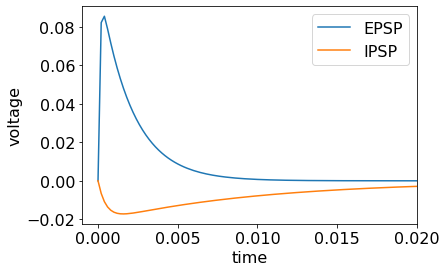

In [13]:
# simulate currents
kernel_e, time_ke = sim_psp(5000, tau_r=0.0001, tau_d=0.002, t_ker=0.05)
kernel_i, time_ki = sim_psp(5000, tau_r=0.0005, tau_d=0.01, t_ker=0.05)

# plot
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(time_ke, kernel_e, label='EPSP')
ax.plot(time_ki, -kernel_i, label='IPSP')
ax.set(xlabel="time", ylabel="voltage")
ax.legend()
ax.set_xlim(-0.001,0.02)
ax.set_title("")
plt.show()

### plot aggregate figure

c:\Users\micha\anaconda3\envs\v1v4\lib\site-packages\ipykernel_launcher.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


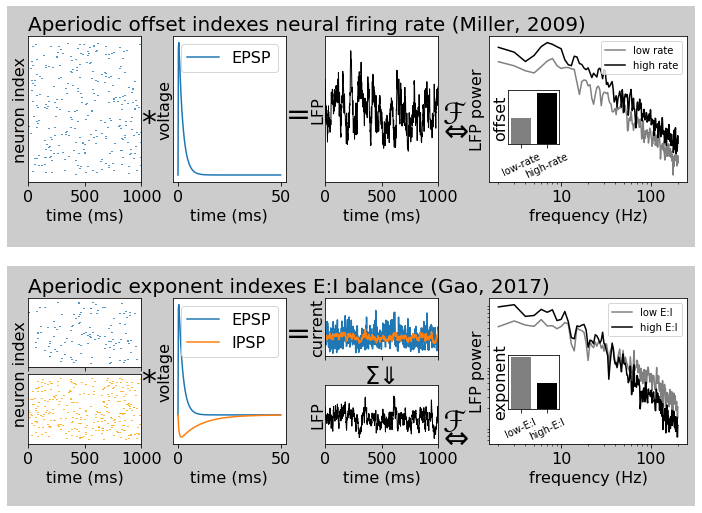

In [15]:
# create panel figure

# settings
fig_width = 11.8
fig_height = 7.5
size_inset_text = 10
eq_size = 30
eq_size_2 = 24

# create figure and gridspec
fig = plt.figure(figsize=[fig_width,fig_height], tight_layout=True)
spec = gridspec.GridSpec(3, 1, figure=fig, hspace=0.5, wspace=0.5,
                         height_ratios=[1, 0.1, 1])

# create gridspec for each row (model)
eq_ax_size = 0.35
width_ratios = [1,eq_ax_size*0.8,1,eq_ax_size,1,eq_ax_size*1.3,1.75]
gs_r0 = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=spec[0,0], 
                                         width_ratios=width_ratios, 
                                         height_ratios=[1], wspace=0)
gs_r1 = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=spec[2,0], 
                                         width_ratios=width_ratios, 
                                         height_ratios=[1], wspace=0)


# # add section headers
# fig.text(0.01, 1.02, 'Aperiodic offset indexes neural firing rate (Miller, 2009)',
#          fontsize=18)
# fig.text(0.01, 0.48, 'Aperiodic exponent indexes E:I balance (Gao, 2017)',
#         fontsize=18)
ax_r0 = fig.add_subplot(spec[0,0])
ax_r0.set_axis_off()
ax_r0.set_title('Aperiodic offset indexes neural firing rate (Miller, 2009)', 
                fontsize=20, loc='left')

ax_r1 = fig.add_subplot(spec[2,0])
ax_r1.set_axis_off()
ax_r1.set_title('Aperiodic exponent indexes E:I balance (Gao, 2017)', 
                fontsize=20, loc='left')

########## Top row: offset model ###############################################
ax_1b = fig.add_subplot(gs_r0[0,0])
ax_1c = fig.add_subplot(gs_r0[0,2])
ax_1d = fig.add_subplot(gs_r0[0,4])
ax_1e = fig.add_subplot(gs_r0[0,6])

# plot subplot 1b
ax_1b.eventplot(spike_times_0)
ax_1b.set(xlabel="time (ms)", ylabel="neuron index")

# plot subplot 1c
ax_1c.plot(time_ke*1000, kernel_e, label="EPSP")
ax_1c.set(xlabel="time (ms)", ylabel="voltage")
ax_1c.legend()

# plot subplot 1d
# create nested gridspec
ax_1d.plot(t_lfp_0*1000, lfp_0, color='k', linewidth=1)
ax_1d.set(xlabel="time (ms)", ylabel="LFP")

# plot subplot 1e
ax_1e.loglog(freq, spectra_0, color='grey')
ax_1e.loglog(freq, spectra_1, color='k')
ax_1e.set(xlabel="frequency (Hz)", ylabel="LFP power")
ax_1e.legend(labels=["low rate","high rate"], loc="upper right", 
             fontsize=size_inset_text)

# plot subplot 1f (embedding in 1e)
ax_1f = fig.add_axes([.69, 0.68, .06, .1], zorder=10, anchor='SW')
ax_1f.bar([0,1], [1,2], color=['grey','k']) # TEMP - placeholder
ax_1f.set(ylabel="offset")
ax_1f.set_xticks([0,1])
ax_1f.set_xticklabels(['low-rate', 'high-rate'], rotation=25, 
                      fontsize=size_inset_text)

### Bottom row: exponent model #################################################

# plot subplot 2b
# create nested gridspec
gs_r2_b = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_r1[0,0], 
                                           hspace=0.1)
ax_2b_a = fig.add_subplot(gs_r2_b[0,0])
ax_2b_a.eventplot(spiketimes_e)

ax_2b_b = fig.add_subplot(gs_r2_b[1,0])
ax_2b_b.eventplot(spiketimes_i, color='orange')
ax_2b_b.set(xlabel="time", ylabel="neuron index")

# plot subplot 2c
ax_2c = fig.add_subplot(gs_r1[0,2])
ax_2c.plot(time_ke*1000, kernel_e, label='EPSP')
ax_2c.plot(time_ki*1000, -kernel_i, label='IPSP')
ax_2c.set(xlabel="time (ms)", ylabel="voltage")
ax_2c.legend()

# plot subplot 2d
gs_r2_d = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_r1[0,4], 
                                           height_ratios=[1,0.5,1], hspace=0)
ax_2d_eq = fig.add_subplot(gs_r2_d[1,0])
ax_2d_eq.set_axis_off()
ax_2d_eq.text(0.35,0.1, "\u03A3\u21d3", size=eq_size_2)

ax_2d_a = fig.add_subplot(gs_r2_d[0,0])
ax_2d_a.plot(t_lfp_2*1000, conductance_e, label='excitatory')
ax_2d_a.plot(t_lfp_2*1000, conductance_i, label='inhibitory')
ax_2d_a.set(ylabel="current")

ax_2d_b = fig.add_subplot(gs_r2_d[2,0])
ax_2d_b.plot(t_lfp_2*1000, lfp_2, color='k', linewidth=1)
ax_2d_b.set(xlabel="time (ms)", ylabel="LFP")

# plot subplot 2e
ax_2e = fig.add_subplot(gs_r1[0,6])
ax_2e.loglog(freq, spectra_3, color='grey')
ax_2e.loglog(freq, spectra_2, color='k')
ax_2e.set(xlabel="frequency (Hz)", ylabel="LFP power")
ax_2e.legend(labels=["low E:I","high E:I"], loc="upper right", 
             fontsize=size_inset_text)

# plot subplot 2f (embedding in 2d)
ax_2f = fig.add_axes([.69, 0.19, .06, .1], zorder=10, anchor='SW')
ax_2f.bar([0,1], [2,1], color=['grey','k']) # TEMP - placeholder
ax_2f.set(ylabel="exponent")
ax_2f.set_xticks([0,1])
ax_2f.set_xticklabels(['low-E:I', 'high-E:I'], rotation=25, 
                      fontsize=size_inset_text)


### Adjust plot appearance #####################################################
# set x limits
for ax in[ax_1d, ax_2d_a, ax_2d_b]:
    ax.set_xlim([0, 1000])
for ax in[ax_1b, ax_2b_a, ax_2b_b]:
    ax.set_xlim([0, 1])

# adjust axis ticks and labels
for ax in [ax_1b, ax_1c, ax_1d, ax_1e, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, 
           ax_2d_b, ax_2e, ax_2f]:
    # ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])

for ax in[ax_2b_a, ax_2d_a]:
    ax.set_xticklabels([])

for ax in [ax_1b, ax_1c, ax_1d, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, 
           ax_2d_b, ax_2f]:
    ax.yaxis.set_label_coords(0, .5)
for ax in [ax_1e, ax_2e]:
    ax.yaxis.set_label_coords(-0.02, .5)

for ax in[ax_1e, ax_2e]:
    ax.set_xticks([10,100])
    ax.set_xticklabels(('10', '100'))
    
for ax in[ax_1d, ax_2d_b]:
    ax.set_xticks([0, 500, 1000])
    ax.set_xticklabels(('0', '500', '1000'))
    
for ax in [ax_1b, ax_2b_b]:
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(('0', '500', '1000'))
    ax.set(xlabel="time (ms)")
ax_1b.set_ylabel("neuron index")
ax_2b_b.set_ylabel("              neuron index")
ax_2b_a.set_xticks([0, 0.5, 1])
ax_2b_a.set_xticklabels([])

### add equation symbols between plots #########################################
ax_1eq0 = fig.add_subplot(gs_r0[0,1])
ax_1eq1 = fig.add_subplot(gs_r0[0,3])
ax_1eq2 = fig.add_subplot(gs_r0[0,5])
ax_2eq0 = fig.add_subplot(gs_r1[0,1])
ax_2eq1 = fig.add_subplot(gs_r1[0,3])
ax_2eq2 = fig.add_subplot(gs_r1[0,5])

for ax in [ax_1eq0, ax_1eq1, ax_1eq2, ax_2eq0, ax_2eq1, ax_2eq2]:
    ax.set_axis_off()
ax_1eq0.text(0.0, 0.35, "\u002a", size=eq_size)
ax_1eq1.text(0.0, 0.4, "=", size=eq_size)
ax_1eq2.text(0.1, 0.28, "\u2131\n\u21D4", size=eq_size, linespacing=0.5)

ax_2eq0.text(0.0, 0.37, "\u002a", size=eq_size)
ax_2eq1.text(0.0, 0.7, "=", size=eq_size)
ax_2eq2.text(0.1, -0.03, "\u2131\n\u21D4", size=eq_size, linespacing=0.5)

# color each row
fig.add_artist(Rectangle((0.1, 0.49), width=0.81, height=0.445, 
                         facecolor='grey', alpha=0.4, zorder=0))
fig.add_artist(Rectangle((0.1, 0.01), width=0.81, height=0.445, 
                         facecolor='grey', alpha=0.4, zorder=0))

plt.savefig(f'{EXTERNAL_PATH}/figures/sfn_2024//known_gao_miller.png', 
            bbox_inches=Bbox([[0, 0],[fig_width+0.2, fig_height+0.2]]), dpi=600)

plt.show()